# Libraries

In [ ]:
import random
import torch
import pickle
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification, BitsAndBytesConfig
from datasets import load_from_disk

from generate_results import generate_answers, generate_SE
from my_utils.data import load_ds, sample_ds, load_results
from my_utils.semantic_entropy import is_entailment_embeddings, is_entailment_transformer, is_entailment_llm
from my_utils.metrics import metric_entail_models
from my_utils.visualisations import visualise_aur_results, visualise_aur_percentages_results, visualise_SE_distribution, visualise_SE_mean_std


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
seed = 42
random.seed(seed)

cuda


# Load datasets

In [2]:
n_samples = 400
_, triviaqa_val = load_ds("trivia_qa", seed)
_, squad_val = load_ds("squad", seed)
_, svamp_val = load_ds("svamp", seed)
_, nq_val = load_ds("nq", seed)


triviaqa_sample = sample_ds(triviaqa_val, n_samples, seed, "trivia_qa")
squad_sample = sample_ds(squad_val, n_samples, seed, "squad")
svamp_sample = sample_ds(svamp_val, n_samples, seed, "svamp")
nq_sample = sample_ds(nq_val, n_samples, seed, "nq")
del triviaqa_val, squad_val, svamp_val, nq_val

datasets = [triviaqa_sample, squad_sample, svamp_sample, nq_sample]

Dataset:  trivia_qa
Dataset({
    features: ['id', 'question', 'context', 'answers'],
    num_rows: 400
}) 

Dataset:  squad
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 400
}) 

Dataset:  svamp
Dataset({
    features: ['ID', 'Body', 'Question', 'Equation', 'Answer', 'Type', 'question_concat', 'question', 'context', 'type', 'equation', 'id', 'answers'],
    num_rows: 400
}) 

Dataset:  nq
Dataset({
    features: ['question', 'answer', 'answers', 'context', 'id'],
    num_rows: 400
}) 



# Generate answers

In [ ]:
# LLM
Gemma_model = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b-it", device_map="auto", torch_dtype=torch.bfloat16)
Gemma_tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")

data_answer_path = "data/answers/"
generate_answers(datasets, data_answer_path, Gemma_model, Gemma_tokenizer)

del Gemma_model, Gemma_tokenizer
torch.cuda.empty_cache()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


Generating responses for trivia_qa dataset...


100%|██████████| 400/400 [25:19<00:00,  3.80s/it]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating responses for squad dataset...


100%|██████████| 400/400 [31:12<00:00,  4.68s/it]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating responses for svamp dataset...


100%|██████████| 400/400 [36:14<00:00,  5.44s/it] 


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating responses for nq dataset...


100%|██████████| 400/400 [27:18<00:00,  4.10s/it]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]

# Load Answers

In [2]:
triviaqa_sample = load_from_disk("data/answers/trivia_qa")
squad_sample = load_from_disk("data/answers/squad")
svamp_sample = load_from_disk("data/answers/svamp")
nq_sample = load_from_disk("data/answers/nq")
Gemma_tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")

datasets = [triviaqa_sample, squad_sample, svamp_sample, nq_sample]

# Calculate Semantic Entropy for different entailment models

## Sentence Embeddings

In [ ]:
All_mpnet_model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2').to(DEVICE)
All_mpnet_tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
data_entail_path = "data/SE/transformers/all_mpnet_base_v2/109M/"
print("\nAll-mpnet-base-v2")
generate_SE(datasets, data_entail_path, Gemma_tokenizer, All_mpnet_model, All_mpnet_tokenizer, is_entailment_embeddings)
del All_mpnet_model, All_mpnet_tokenizer
torch.cuda.empty_cache()


All-mpnet-base-v2

Generating Semantic Entropies for trivia_qa dataset...


100%|██████████| 400/400 [00:35<00:00, 11.30it/s]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for squad dataset...


100%|██████████| 400/400 [00:37<00:00, 10.74it/s]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for svamp dataset...


100%|██████████| 400/400 [00:39<00:00, 10.23it/s]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for nq dataset...


100%|██████████| 400/400 [00:36<00:00, 10.85it/s]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]

## Transformers

In [4]:
Roberta_model = AutoModelForSequenceClassification.from_pretrained("roberta-large-mnli").to(DEVICE)
Roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-large-mnli")
data_entail_path = "data/SE/transformers/roberta/356M/"
print("\nRoberta")
generate_SE(datasets, data_entail_path, Gemma_tokenizer, Roberta_model, Roberta_tokenizer, is_entailment_transformer)
del Roberta_model, Roberta_tokenizer
torch.cuda.empty_cache()

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Roberta

Generating Semantic Entropies for trivia_qa dataset...


  0%|          | 0/400 [00:00<?, ?it/s]c:\Users\tasso\anaconda3\envs\mscs\Lib\site-packages\transformers\models\roberta\modeling_roberta.py:370: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 400/400 [02:01<00:00,  3.28it/s]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for squad dataset...


100%|██████████| 400/400 [02:07<00:00,  3.14it/s]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for svamp dataset...


100%|██████████| 400/400 [02:00<00:00,  3.32it/s]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for nq dataset...


100%|██████████| 400/400 [01:48<00:00,  3.69it/s]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]

In [3]:
Deberta_model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-large").to(DEVICE)
Deberta_tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-large")
data_entail_path = "data/SE/transformers/deberta/304M/"
print("\nDeberta")
generate_SE(datasets, data_entail_path, Gemma_tokenizer, Deberta_model, Deberta_tokenizer, is_entailment_transformer)
del Deberta_model, Deberta_tokenizer
torch.cuda.empty_cache()

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\tasso\anaconda3\envs\mscs\Lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(



Deberta

Generating Semantic Entropies for trivia_qa dataset...


100%|██████████| 400/400 [04:15<00:00,  1.57it/s]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for squad dataset...


100%|██████████| 400/400 [04:36<00:00,  1.45it/s]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for svamp dataset...


100%|██████████| 400/400 [04:41<00:00,  1.42it/s]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for nq dataset...


100%|██████████| 400/400 [04:31<00:00,  1.48it/s]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]

In [2]:
mem_b = torch.cuda.memory_allocated()
Deberta_model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-large").to(DEVICE)
Deberta_tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-large")
mem_a = torch.cuda.memory_allocated()
print(mem_a -mem_b)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1740259840


c:\Users\tasso\anaconda3\envs\mscs\Lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [3]:
Deberta_model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v2-xxlarge-mnli").to(DEVICE)
Deberta_tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v2-xxlarge-mnli")
data_entail_path = "data/SE/transformers/deberta/1.5B/"
print("\nDeberta")
generate_SE(datasets, data_entail_path, Gemma_tokenizer, Deberta_model, Deberta_tokenizer, is_entailment_transformer)
del Deberta_model, Deberta_tokenizer
torch.cuda.empty_cache()


Deberta

Generating Semantic Entropies for trivia_qa dataset...


100%|██████████| 400/400 [26:42<00:00,  4.01s/it]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for squad dataset...


100%|██████████| 400/400 [27:17<00:00,  4.09s/it]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for svamp dataset...


100%|██████████| 400/400 [35:29<00:00,  5.32s/it]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for nq dataset...


100%|██████████| 400/400 [19:01<00:00,  2.85s/it]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]

## LLMs

### Qwen

In [6]:
Qwen_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct", torch_dtype="auto", device_map="auto").to(DEVICE)
Qwen_tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct")
data_entail_path = "data/SE/llms/qwen/0.5B/"
print("\nQwen 0.5B")
generate_SE(datasets, data_entail_path, Gemma_tokenizer, Qwen_model, Qwen_tokenizer, is_entailment_llm)
del Qwen_model, Qwen_tokenizer
torch.cuda.empty_cache()


Qwen 0.5B

Generating Semantic Entropies for trivia_qa dataset...


  0%|          | 0/400 [00:00<?, ?it/s]c:\Users\tasso\anaconda3\envs\mscs\Lib\site-packages\transformers\models\qwen2\modeling_qwen2.py:544: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 400/400 [42:10<00:00,  6.33s/it] 


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for squad dataset...


100%|██████████| 400/400 [39:50<00:00,  5.98s/it]  


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for svamp dataset...


100%|██████████| 400/400 [1:48:43<00:00, 16.31s/it]  


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for nq dataset...


100%|██████████| 400/400 [24:47<00:00,  3.72s/it] 


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]

In [ ]:
Qwen_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-1.5B-Instruct", torch_dtype="auto", device_map="auto").to(DEVICE)
Qwen_tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-1.5B-Instruct")
data_entail_path = "data/SE/llms/qwen/1.5B/"
print("\nQwen 1.5B")
generate_SE(datasets, data_entail_path, Gemma_tokenizer, Qwen_model, Qwen_tokenizer, is_entailment_llm)
del Qwen_model, Qwen_tokenizer
torch.cuda.empty_cache()


Qwen 1.5B

Generating Semantic Entropies for trivia_qa dataset...


100%|██████████| 400/400 [13:36<00:00,  2.04s/it]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for squad dataset...


100%|██████████| 400/400 [15:07<00:00,  2.27s/it]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for svamp dataset...


100%|██████████| 400/400 [09:08<00:00,  1.37s/it]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for nq dataset...


100%|██████████| 400/400 [15:06<00:00,  2.27s/it]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]

In [3]:
Qwen_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-3B-Instruct", torch_dtype="auto", device_map="auto").to(DEVICE)
Qwen_tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-3B-Instruct")
data_entail_path = "data/SE/llms/qwen/3.0B/"
print("\nQwen 3B")
generate_SE(datasets, data_entail_path, Gemma_tokenizer, Qwen_model, Qwen_tokenizer, is_entailment_llm)
del Qwen_model, Qwen_tokenizer
torch.cuda.empty_cache()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


Qwen 3B

Generating Semantic Entropies for trivia_qa dataset...


  0%|          | 0/400 [00:00<?, ?it/s]c:\Users\tasso\anaconda3\envs\mscs\Lib\site-packages\transformers\models\qwen2\modeling_qwen2.py:544: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 400/400 [1:15:57<00:00, 11.39s/it]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for squad dataset...


100%|██████████| 400/400 [2:24:58<00:00, 21.75s/it]  


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for svamp dataset...


100%|██████████| 400/400 [2:37:52<00:00, 23.68s/it]  


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for nq dataset...


100%|██████████| 400/400 [1:23:51<00:00, 12.58s/it]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]

### Gemma

In [3]:
Gemma_model = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b-it", torch_dtype="auto", device_map="auto")
data_entail_path = "data/SE/llms/gemma/2.0B/"
print("\nGemma 2.0B")
generate_SE(datasets, data_entail_path, Gemma_tokenizer, Gemma_model, Gemma_tokenizer, is_entailment_llm)
del Gemma_model
torch.cuda.empty_cache()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


Gemma 2.0B

Generating Semantic Entropies for trivia_qa dataset...


100%|██████████| 400/400 [5:04:41<00:00, 45.70s/it]  


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for squad dataset...


100%|██████████| 400/400 [5:47:50<00:00, 52.18s/it]  


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for svamp dataset...


100%|██████████| 400/400 [6:03:46<00:00, 54.57s/it]  


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for nq dataset...


100%|██████████| 400/400 [5:06:32<00:00, 45.98s/it]  


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]

In [ ]:
quantization_config = BitsAndBytesConfig(load_in_8bit=True)
Gemma_model_8bit = AutoModelForCausalLM.from_pretrained("google/gemma-2-9b-it", quantization_config=quantization_config, torch_dtype="auto", low_cpu_mem_usage=True)
Gemma_tokenizer_8bit = AutoTokenizer.from_pretrained("google/gemma-2-9b-it")
data_entail_path = "data/SE/llms/gemma/9.0B/"
print("\nGemma 9.0B")
generate_SE(datasets, data_entail_path, Gemma_tokenizer, Gemma_model_8bit, Gemma_tokenizer_8bit, is_entailment_llm)
del Gemma_model_8bit, Gemma_tokenizer_8bit
torch.cuda.empty_cache()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


Gemma 9.0B

Generating Semantic Entropies for trivia_qa dataset...


100%|██████████| 400/400 [7:46:08<00:00, 69.92s/it]   


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for squad dataset...


100%|██████████| 400/400 [10:09:16<00:00, 91.39s/it]  


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for svamp dataset...


100%|██████████| 400/400 [10:31:23<00:00, 94.71s/it]  


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for nq dataset...


100%|██████████| 400/400 [8:14:21<00:00, 74.15s/it]   


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]

### Llama

In [3]:
Llama_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B-Instruct").to(DEVICE)
Llama_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")
data_entail_path = "data/SE/llms/llama3_2/1.0B/"
print("\nLlama 3.2 1B")
generate_SE(datasets, data_entail_path, Gemma_tokenizer, Llama_model, Llama_tokenizer, is_entailment_llm)
del Llama_model, Llama_tokenizer
torch.cuda.empty_cache()


Llama 3.2 1B

Generating Semantic Entropies for trivia_qa dataset...


  0%|          | 0/400 [00:00<?, ?it/s]c:\Users\tasso\anaconda3\envs\mscs\Lib\site-packages\transformers\models\llama\modeling_llama.py:602: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 400/400 [45:51<00:00,  6.88s/it]  


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for squad dataset...


100%|██████████| 400/400 [1:15:31<00:00, 11.33s/it]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for svamp dataset...


100%|██████████| 400/400 [1:47:14<00:00, 16.09s/it]  


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for nq dataset...


100%|██████████| 400/400 [58:30<00:00,  8.78s/it]  


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]

# Load Results

In [5]:
transformers_results, transformers_names = load_results("data/SE/transformers", "Transformer")
llm_results, llm_names = load_results("data/SE/llms", "LLM")

transformers_names[0] = "Transformer All-MPNet 109M"
datasets_names = ["NQ Open", "SQuAD", "SVAMP", "Trivia QA"]
models_names = transformers_names + llm_names

unique_models = list(set(models_names))
unique_models.sort()

colours = [
    "#56B4E9",  # Sky Blue
    "#FF0000",  # Red
    "#F0E442",  # Yellow  
    "#882255",  # Deep Purple
    "#0072B2",  # Blue
    "#009E73",  # Green 
    "#D55E00",  # Orange
    "#99E699",  # Light Green
    "#CC79A7",  # Pink    
]

model_to_colour = {model: colour for model, colour in zip(unique_models, colours)}

Loaded nq from all_mpnet_base_v2/109M
Loaded squad from all_mpnet_base_v2/109M
Loaded svamp from all_mpnet_base_v2/109M
Loaded trivia_qa from all_mpnet_base_v2/109M

Loaded nq from deberta/304M
Loaded squad from deberta/304M
Loaded svamp from deberta/304M
Loaded trivia_qa from deberta/304M

Loaded nq from roberta/356M
Loaded squad from roberta/356M
Loaded svamp from roberta/356M
Loaded trivia_qa from roberta/356M

Loaded nq from gemma/2.0B
Loaded squad from gemma/2.0B
Loaded svamp from gemma/2.0B
Loaded trivia_qa from gemma/2.0B

Loaded nq from gemma/9.0B
Loaded squad from gemma/9.0B
Loaded svamp from gemma/9.0B
Loaded trivia_qa from gemma/9.0B

Loaded nq from llama3_2/1.0B
Loaded squad from llama3_2/1.0B
Loaded svamp from llama3_2/1.0B
Loaded trivia_qa from llama3_2/1.0B

Loaded nq from qwen/0.5B
Loaded squad from qwen/0.5B
Loaded svamp from qwen/0.5B
Loaded trivia_qa from qwen/0.5B

Loaded nq from qwen/1.5B
Loaded squad from qwen/1.5B
Loaded svamp from qwen/1.5B
Loaded trivia_qa from

# Calculate Metrics

## AUROC


AUROC scores for All_mpnet_base_v2 109M
nq                   dataset:   0.4761
squad                dataset:   0.4856
svamp                dataset:   0.5708
trivia_qa            dataset:   0.5706

AUROC scores for Deberta 304M
nq                   dataset:   0.5975
squad                dataset:   0.4845
svamp                dataset:   0.5678
trivia_qa            dataset:   0.5726

AUROC scores for Roberta 356M
nq                   dataset:   0.6535
squad                dataset:   0.5342
svamp                dataset:   0.5722
trivia_qa            dataset:   0.6088

AUROC scores for Gemma 2.0B
nq                   dataset:   0.6214
squad                dataset:   0.5448
svamp                dataset:   0.5218
trivia_qa            dataset:   0.6197

AUROC scores for Gemma 9.0B
nq                   dataset:   0.6230
squad                dataset:   0.5462
svamp                dataset:   0.3841
trivia_qa            dataset:   0.6074

AUROC scores for Llama3_2 1.0B
nq                   datase

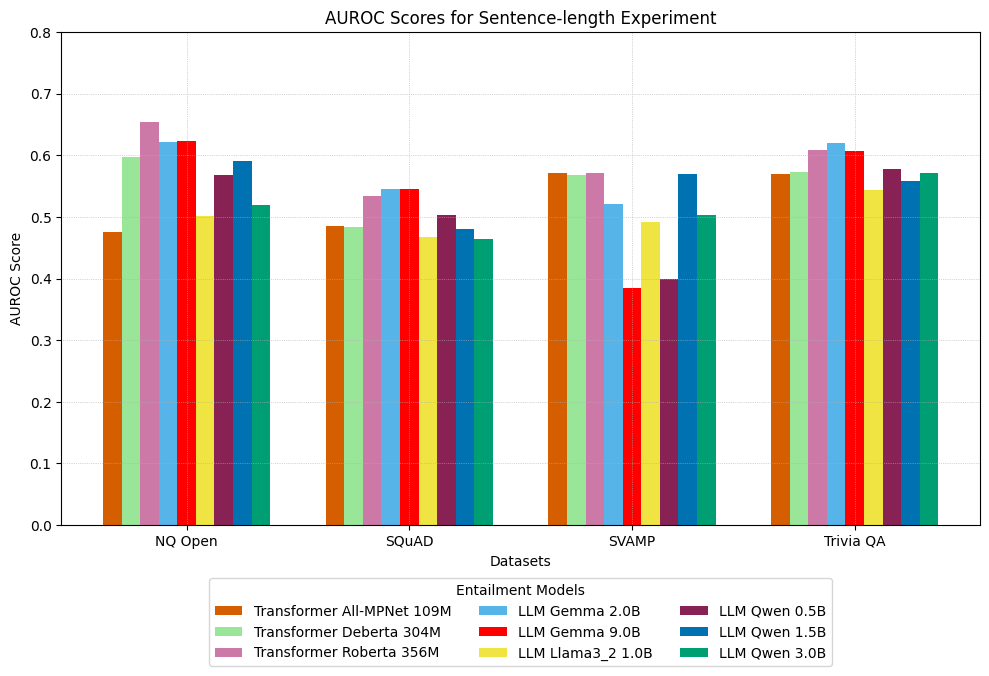

In [6]:
auroc_tr = metric_entail_models(transformers_results, "AUROC")
auroc_lr = metric_entail_models(llm_results, "AUROC")

visualise_aur_results(models_names, datasets_names, auroc_tr+auroc_lr, model_to_colour, "AUROC")

## Semantic Entropy

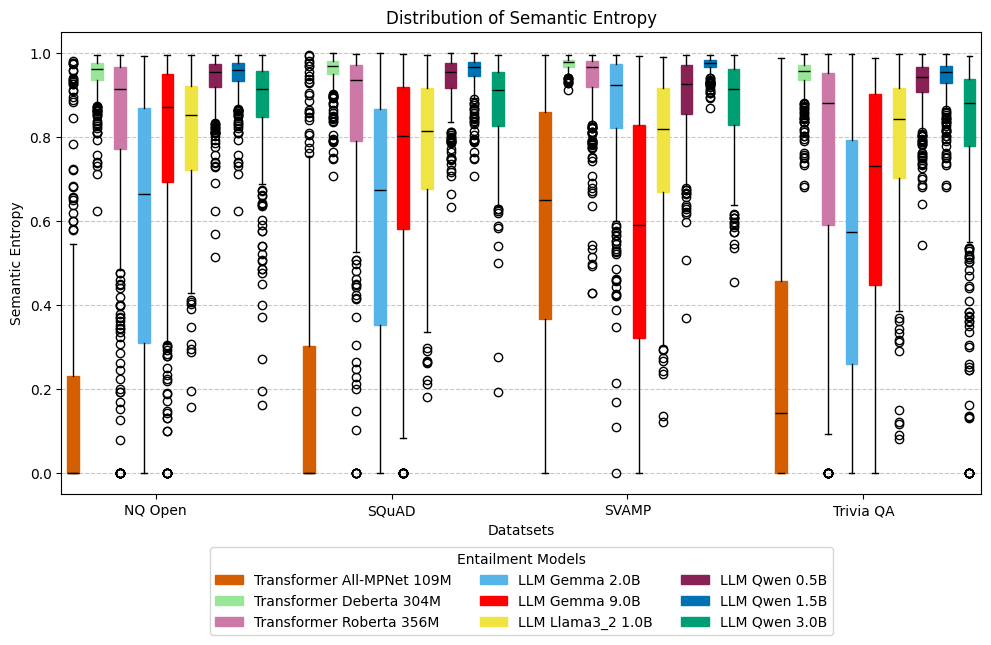

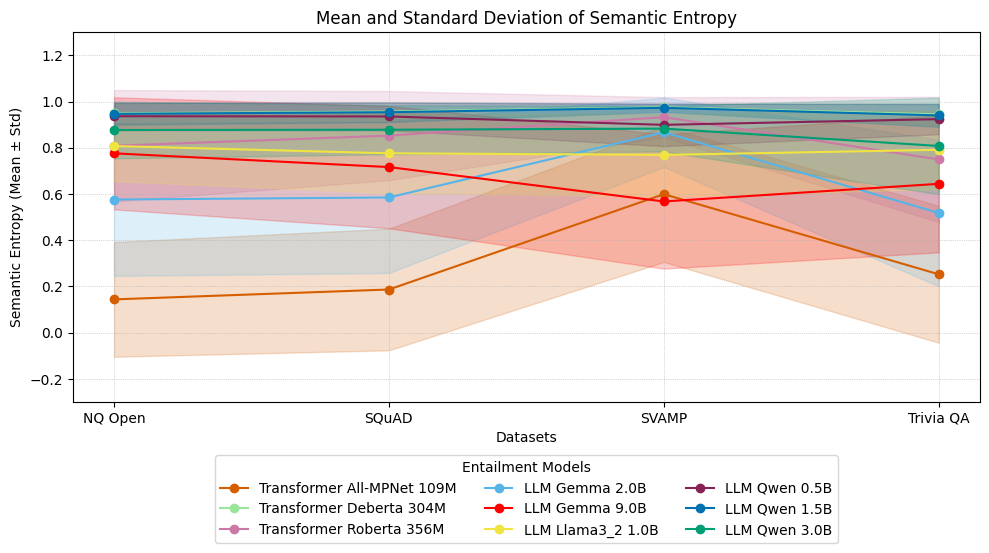

In [7]:
SE_tr = metric_entail_models(transformers_results, "SE")
SE_lr = metric_entail_models(llm_results, "SE")

visualise_SE_distribution(models_names, datasets_names, SE_tr+SE_lr, model_to_colour)
visualise_SE_mean_std(models_names, datasets_names, SE_tr+SE_lr, model_to_colour)

## AURAC


AURAC scores for All_mpnet_base_v2 109M
nq                   dataset:   0.4637
squad                dataset:   0.4359
svamp                dataset:   0.5640
trivia_qa            dataset:   0.5340

AURAC scores for Deberta 304M
nq                   dataset:   0.5637
squad                dataset:   0.4999
svamp                dataset:   0.5744
trivia_qa            dataset:   0.2354

AURAC scores for Roberta 356M
nq                   dataset:   0.5982
squad                dataset:   0.5203
svamp                dataset:   0.5820
trivia_qa            dataset:   0.2744

AURAC scores for Gemma 2.0B
nq                   dataset:   0.5872
squad                dataset:   0.5413
svamp                dataset:   0.5400
trivia_qa            dataset:   0.3422

AURAC scores for Gemma 9.0B
nq                   dataset:   0.5775
squad                dataset:   0.5468
svamp                dataset:   0.4200
trivia_qa            dataset:   0.2734

AURAC scores for Llama3_2 1.0B
nq                   datase

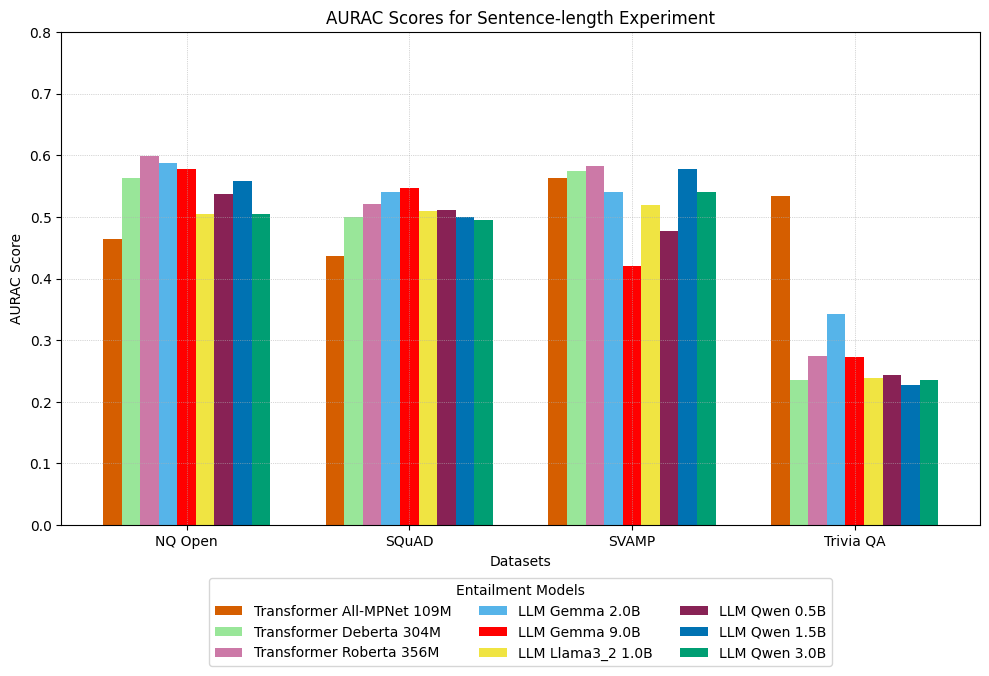

In [8]:
aurac_tr = metric_entail_models(transformers_results, "AURAC")
aurac_lr = metric_entail_models(llm_results, "AURAC")

visualise_aur_results(models_names, datasets_names, aurac_tr+aurac_lr, model_to_colour, "AURAC")


AURAC % scores for All_mpnet_base_v2 109M
nq                   dataset:   0.4637
squad                dataset:   0.4359
svamp                dataset:   0.5640
trivia_qa            dataset:   0.5340

AURAC % scores for Deberta 304M
nq                   dataset:   0.5637
squad                dataset:   0.4999
svamp                dataset:   0.5744
trivia_qa            dataset:   0.2354

AURAC % scores for Roberta 356M
nq                   dataset:   0.5982
squad                dataset:   0.5203
svamp                dataset:   0.5820
trivia_qa            dataset:   0.2744

AURAC % scores for Gemma 2.0B
nq                   dataset:   0.5872
squad                dataset:   0.5413
svamp                dataset:   0.5400
trivia_qa            dataset:   0.3422

AURAC % scores for Gemma 9.0B
nq                   dataset:   0.5775
squad                dataset:   0.5468
svamp                dataset:   0.4200
trivia_qa            dataset:   0.2734

AURAC % scores for Llama3_2 1.0B
nq             

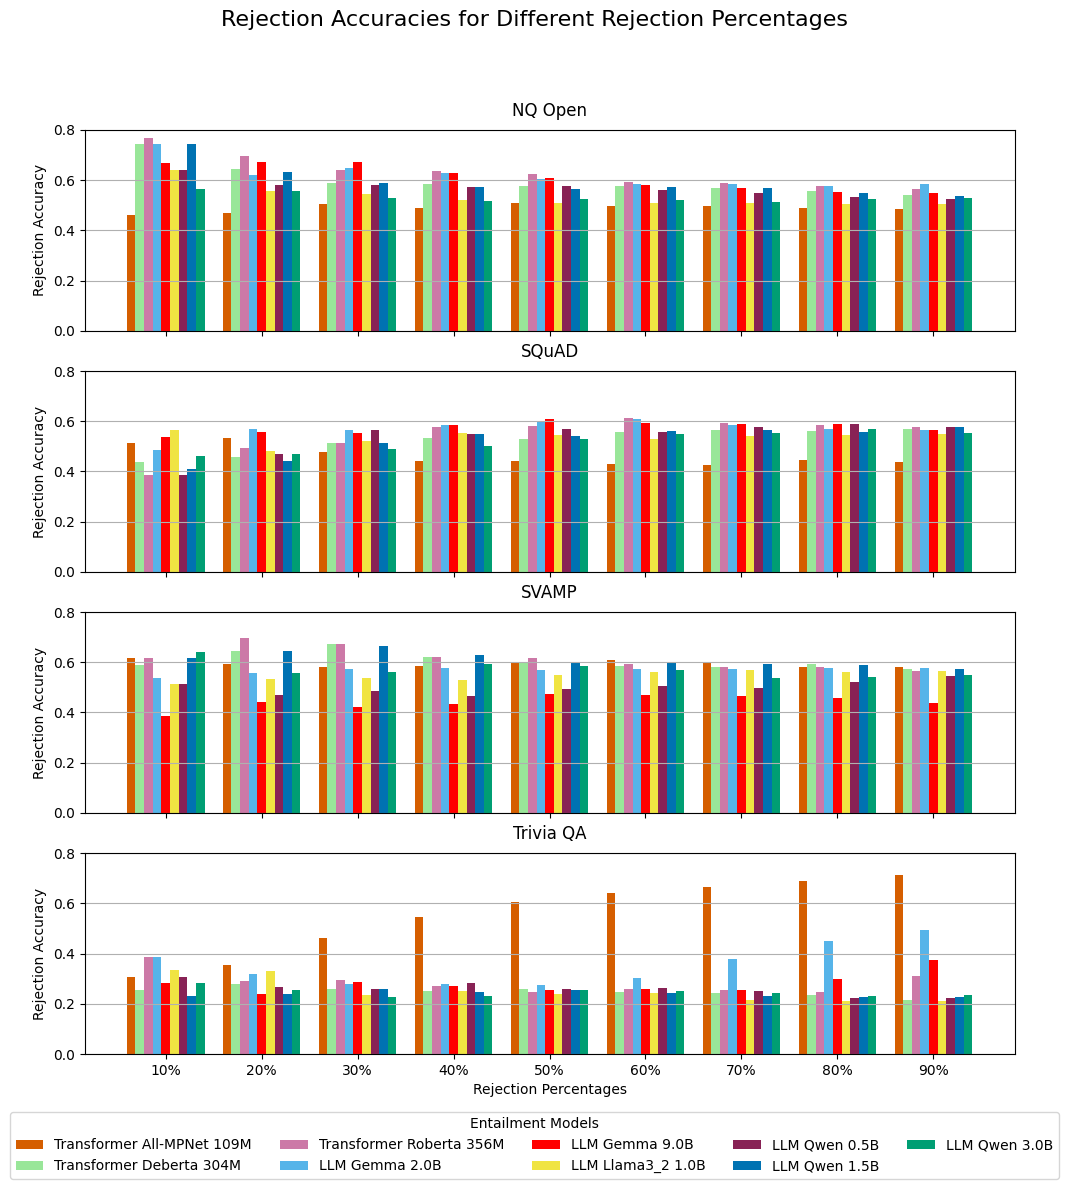

In [9]:
aurac_per_tr = metric_entail_models(transformers_results, "AURAC %")
aurac_per_lr = metric_entail_models(llm_results, "AURAC %")

visualise_aur_percentages_results(models_names, datasets_names, aurac_per_tr+aurac_per_lr, model_to_colour)

## F1-score


F1 scores for All_mpnet_base_v2 109M
nq                   dataset:   0.1538
squad                dataset:   0.2064
svamp                dataset:   0.6569
trivia_qa            dataset:   0.3353

F1 scores for Deberta 304M
nq                   dataset:   0.6820
squad                dataset:   0.7159
svamp                dataset:   0.7179
trivia_qa            dataset:   0.3539

F1 scores for Roberta 356M
nq                   dataset:   0.7071
squad                dataset:   0.7179
svamp                dataset:   0.7161
trivia_qa            dataset:   0.3882

F1 scores for Gemma 2.0B
nq                   dataset:   0.6449
squad                dataset:   0.6358
svamp                dataset:   0.7148
trivia_qa            dataset:   0.3935

F1 scores for Gemma 9.0B
nq                   dataset:   0.6764
squad                dataset:   0.6909
svamp                dataset:   0.4934
trivia_qa            dataset:   0.3848

F1 scores for Llama3_2 1.0B
nq                   dataset:   0.6621
squad 

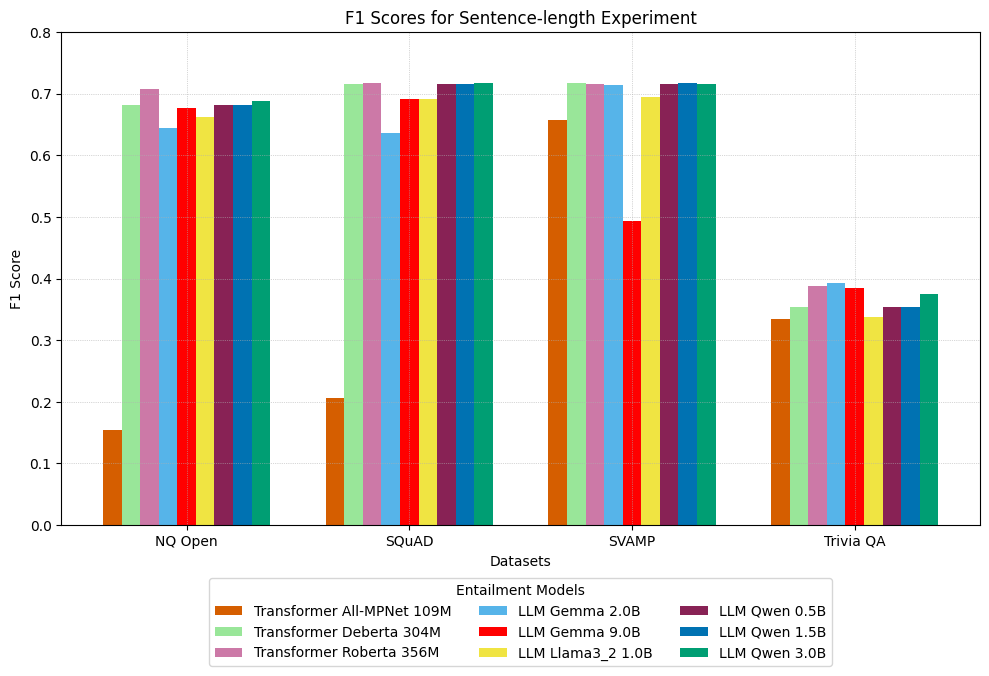

In [10]:
f1_tr = metric_entail_models(transformers_results, "F1")
f1_lr = metric_entail_models(llm_results, "F1")

visualise_aur_results(models_names, datasets_names, f1_tr+f1_lr, model_to_colour, "F1")

## Memory

In [11]:
mem_tr = metric_entail_models(transformers_results, "MEMORY")
mem_lr = metric_entail_models(llm_results, "MEMORY")


Memory allocation in MB for All_mpnet_base_v2 109M
nq         |  Mean:    1.626    Std:   0.696
squad      |  Mean:    1.807    Std:   0.828
svamp      |  Mean:    2.288    Std:   0.799
trivia_qa  |  Mean:    1.477    Std:   0.783

Memory allocation in MB for Deberta 304M
nq         |  Mean: 2311.612    Std: 596.625
squad      |  Mean: 2442.964    Std: 701.245
svamp      |  Mean: 2825.360    Std: 740.593
trivia_qa  |  Mean: 2110.512    Std: 556.191

Memory allocation in MB for Roberta 356M
nq         |  Mean:  769.336    Std: 291.293
squad      |  Mean:  835.679    Std: 332.559
svamp      |  Mean: 1056.626    Std: 363.978
trivia_qa  |  Mean:  683.939    Std: 263.282

Memory allocation in MB for Gemma 2.0B
nq         |  Mean:    0.039    Std:   0.005
squad      |  Mean:    0.041    Std:   0.007
svamp      |  Mean:    0.045    Std:   0.006
trivia_qa  |  Mean:    0.191    Std:   2.574

Memory allocation in MB for Gemma 9.0B
nq         |  Mean:    0.038    Std:   0.006
squad      |  Mean: